# 전력사용량 데이터 전이학습

- 기학습 모형 :  m4 데이터 이용
- 타겟데이터 : 일별 전력사용량 데이터
- 인풋사이즈 ; 21
- 아웃풋사이즈 ; 7


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nbeats_keras.model import NBeatsNet as NBeatsKeras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from nbeats_pytorch.model import NBeatsNet as NBeatsPytorch
from keras.optimizers import RMSprop, Adam
import time

#from pretraindata_simulation18_6_scale import X_train,y_train
from m4databasis21_7 import base_domain,zt_in,zt_out,M4Meta,inputsize,train_12,train_12_y
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

C:\Users\default.DESKTOP-2ISHQBS\lab\task2_kim\m4databasis21_7.py:315: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  lst = pd.DataFrame([np.array([dct[j].timeseries[i][-inputsize[group]:] for i in range(len(dct[j].timeseries))] )for j in dct_name ][ group ])


In [1]:
from target_data_electronic_21_7 import target_X, target_y ,test_X, test_y

In [2]:
target_X.shape, target_y.shape ,test_X.shape, test_y.shape

((3624, 21), (3624, 7), (337, 21), (337, 7))

## pretrained model

In [5]:
K.clear_session()

input_dim, output_dim =  1, 1
backcast_, forecast_ = 21,7

model= NBeatsKeras( backcast_length=backcast_, forecast_length=forecast_, input_dim=input_dim,
                   output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                      NBeatsKeras.TREND_BLOCK,
                                                       NBeatsKeras.SEASONALITY_BLOCK,
                                                      NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                   ,nb_blocks_per_stack=4, thetas_dim=(1,2,2,4,4,4),
                   share_weights_in_stack=True, hidden_layer_units=128)
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer )
early_stop = EarlyStopping(monitor='loss', patience=100, verbose=1, restore_best_weights=False)
#checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
#model.save('best_model.h9')
history = model.fit(train_12,train_12_y, validation_data=(test_X, test_y ),
                    epochs=100
                    , batch_size=128,
                    callbacks=[early_stop])


Epoch 1/100
782/782 [==============================] - 26s 28ms/step - loss: 4.9528e-04 - val_loss: 0.0465
Epoch 2/100
782/782 [==============================] - 19s 24ms/step - loss: 1.4328e-05 - val_loss: 0.0489
Epoch 3/100
782/782 [==============================] - 19s 24ms/step - loss: 1.3202e-05 - val_loss: 0.0330
Epoch 4/100
782/782 [==============================] - 18s 23ms/step - loss: 1.3403e-05 - val_loss: 0.0341
Epoch 5/100
782/782 [==============================] - 19s 24ms/step - loss: 1.2348e-05 - val_loss: 0.0289
Epoch 6/100
782/782 [==============================] - 19s 24ms/step - loss: 1.1494e-05 - val_loss: 0.0308
Epoch 7/100
782/782 [==============================] - 18s 23ms/step - loss: 1.2013e-05 - val_loss: 0.0290
Epoch 8/100
782/782 [==============================] - 19s 24ms/step - loss: 1.0885e-05 - val_loss: 0.0310
Epoch 9/100
782/782 [==============================] - 19s 24ms/step - loss: 1.0473e-05 - val_loss: 0.0281
Epoch 10/100
782/782 [===============

## 파라미터 셋팅

In [6]:
# nbeat_lstm 파라미터
horizon =7
lookback = 3
backcast_length = horizon*lookback
#theta_dim1, theta_dim2 = 72,24
forecast_length = horizon
unit=128

# nbeats 파라미터
input_dim, output_dim =  1, 1
backcast= horizon*lookback
forecast = horizon #7

# lstm 모형생성
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Lambda, Input, Reshape, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
def build_model(input_timesteps=backcast, output_timesteps=horizon, features=1):
    model_lstm = Sequential()
    model_lstm.add(LSTM(128, return_sequences=True, input_shape=(input_timesteps, features)))
    # Use Lambda layer to select the last 'output_timesteps' outputs
    model_lstm.add(Lambda(lambda x: x[:, -output_timesteps:, :]))
    model_lstm.add(TimeDistributed(Dense(1)))
    model_lstm.compile(loss='mse', optimizer='adam')
    return model_lstm


In [99]:
TS_ID = 10
epoch=50

#######################################################################################################################################
nbeats_lstm_pretrain_score=[]   
nbeats_lstm_pretrain_lst=[]
nbeats_lstm_pretrain_time = []

for  i in range(TS_ID ):
    K.clear_session()
    for layer in model.layers:
        layer.trainable = False
    pretrained_layers = model.layers[:-1]
    pretrained_model = Model(inputs=model.input, outputs=pretrained_layers[-1].output)


    input1 = Input(shape=(backcast_length,1))
    pretrained_output = pretrained_model(input1)
    pretrained_output_reshaped = Reshape((forecast_length,-1))(pretrained_output)

# LSTM layer
    lstm_output = Bidirectional(LSTM(32,return_sequences=True))(pretrained_output_reshaped )

    dense_output = TimeDistributed(Dense(1))(lstm_output)

    model_combined = Model(inputs=input1, outputs=dense_output)
    model_combined.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    nbeat_time1 = time.time()
    history2 = model_combined.fit(target_X, target_y ,validation_data=[test_X, test_y],
                             epochs=epoch, batch_size=4,
                             callbacks=[early_stop], verbose=0)
    nbeat_time2 = time.time()
    #total_training_time0 =nbeat_time2- nbeat_time1
    #nbeat_pred = model_combined.predict(X_test1)
    pred = model_combined.predict(test_X)
    me1= mean_squared_error( test_y.flatten(),pred.flatten())
    me2=mean_absolute_error( test_y.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error( test_y.flatten(),pred.flatten())
    
    nbeats_lstm_pretrain_lst.append(pred.flatten())
    nbeats_lstm_pretrain_score.append([me1,me2,me3])
    nbeats_lstm_pretrain_time.append(nbeat_time2-nbeat_time1)
    

#######################################################################################################################################
nbeats_lstm_pretrain_score2=[]   
nbeats_lstm_pretrain_lst2=[]
nbeats_lstm_pretrain_time2 = []

for  i in range(TS_ID ):
    K.clear_session()
    for layer in model.layers:
        layer.trainable = True
    pretrained_layers = model.layers[:-1]
    pretrained_model = Model(inputs=model.input, outputs=pretrained_layers[-1].output)


    input1 = Input(shape=(backcast_length,1))
    pretrained_output = pretrained_model(input1)
    pretrained_output_reshaped = Reshape((forecast_length,-1))(pretrained_output)

# LSTM layer
    lstm_output = Bidirectional(LSTM(32,return_sequences=True))(pretrained_output_reshaped )

    dense_output = TimeDistributed(Dense(1))(lstm_output)

    model_combined = Model(inputs=input1, outputs=dense_output)
    model_combined.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    nbeat_time1 = time.time()
    history2 = model_combined2.fit(target_X, target_y ,validation_data=[test_X, test_y],
                             epochs=epoch, batch_size=4,
                             callbacks=[early_stop], verbose=0)
    nbeat_time2 = time.time()
    #total_training_time0 =nbeat_time2- nbeat_time1
    #nbeat_pred = model_combined.predict(X_test1)
    pred = model_combined.predict(test_X)
    me1= mean_squared_error( test_y.flatten(),pred.flatten())
    me2=mean_absolute_error( test_y.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error( test_y.flatten(),pred.flatten())
    
    nbeats_lstm_pretrain_lst2.append(pred.flatten())
    nbeats_lstm_pretrain_score2.append([me1,me2,me3])
    nbeats_lstm_pretrain_time2.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################

nbeats_pred_score = []
nbeats_pred_lst = []
nbeats_pred_time = []



for i in range(TS_ID):
    K.clear_session()
    nbeats_model= NBeatsKeras( backcast_length=backcast, forecast_length=forecast, input_dim=input_dim,
                       output_dim=output_dim,stack_types=(NBeatsKeras.TREND_BLOCK,NBeatsKeras.TREND_BLOCK,
                                                          NBeatsKeras.SEASONALITY_BLOCK,NBeatsKeras.SEASONALITY_BLOCK)
                       ,nb_blocks_per_stack=4, thetas_dim=(1,2,4,4),
                       share_weights_in_stack=True, hidden_layer_units=128)
    optimizer = Adam(learning_rate=0.001)
    nbeats_model.compile(loss='mse', optimizer=optimizer )

    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0, restore_best_weights=False)
    #checkpoint = ModelCheckpoint('best_model.h9', monitor='loss', save_best_only=True, mode='max', verbose=1)
    #model.save('best_model.h9')
    nbeat_time1 = time.time()
    history = nbeats_model.fit(target_X, target_y ,validation_data=[test_X, test_y],
                        epochs=epoch, batch_size=4, verbose=0,
                        callbacks=[early_stop])
    nbeat_time2 = time.time()
    
    pred = nbeats_model.predict(test_X)
    me1= mean_squared_error( test_y.flatten(),pred.flatten())
    me2=mean_absolute_error( test_y.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error( test_y.flatten(),pred.flatten())
    
    nbeats_pred_lst.append(pred.flatten())
    nbeats_pred_score.append([me1,me2,me3])
    nbeats_pred_time.append(nbeat_time2-nbeat_time1)
    
#######################################################################################################################################


lstm_pred_score = []
lstm_pred_lst = []
lstm_pred_time = []

for i in range(TS_ID):
    K.clear_session()
    lstm_model = build_model()
    early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
    time1 = time.time()
    history = lstm_model.fit(target_X, target_y ,validation_data=[test_X, test_y], 
                        epochs=epoch, batch_size=4, verbose=0, callbacks=[early_stop])
    time2 = time.time()    
    pred = lstm_model.predict(test_X)
    me1= mean_squared_error( test_y.flatten(),pred.flatten())
    me2=mean_absolute_error( test_y.flatten(),pred.flatten())
    me3=mean_absolute_percentage_error( test_y.flatten(),pred.flatten())
    
    lstm_pred_lst.append(pred.flatten())
    lstm_pred_score.append([me1,me2,me3])
    lstm_pred_time.append(time2-time1)

11/11 [==============================] - 0s 7ms/step


In [109]:

metrix_df = pd.DataFrame({'nbeat_tp_freezing':np.array(nbeats_lstm_pretrain_score).mean(axis=0),
             'nbeat_tp_finetuing':np.array(nbeats_lstm_pretrain_score2).mean(axis=0),
             'only_nbeats':np.array(nbeats_pred_score).mean(axis=0),
             'only_lstm':np.array(lstm_pred_score).mean(axis=0)}).T
#metrix_df.index = ['MSE','MAE','MAPE']
metrix_df.columns = ['MSE','MAE','MAPE']
metrix_df

MSE       MAE      MAPE
nbeat_tp_freezing   0.007300  0.058834  0.125122
nbeat_tp_finetuing  0.313687  0.531248  0.936798
only_nbeats         0.008259  0.062268  0.131203
only_lstm           0.009745  0.068270  0.142548

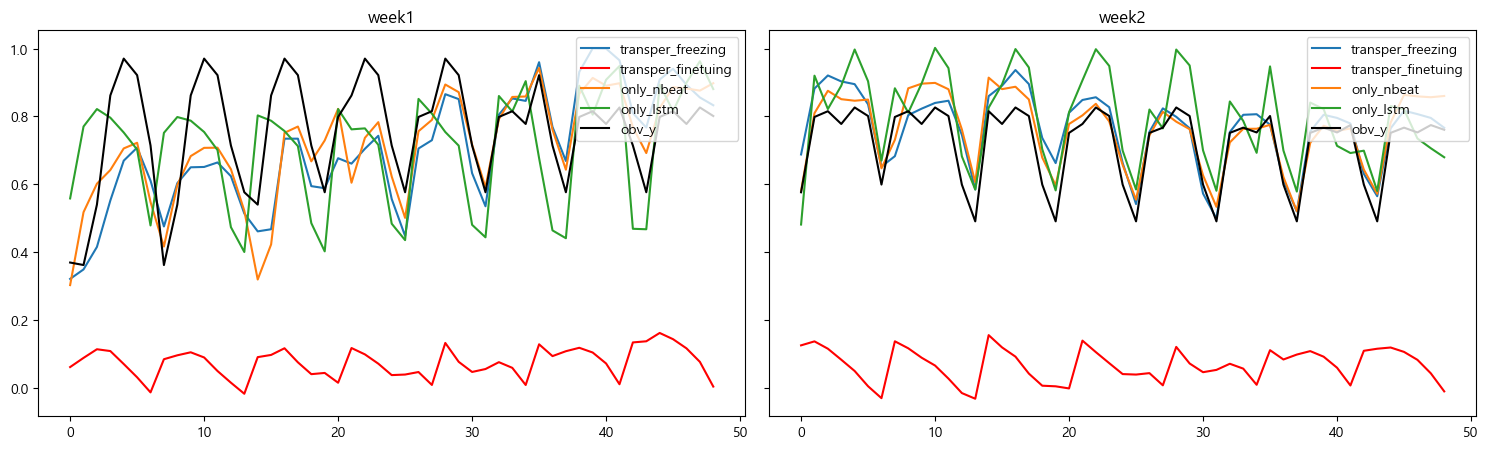

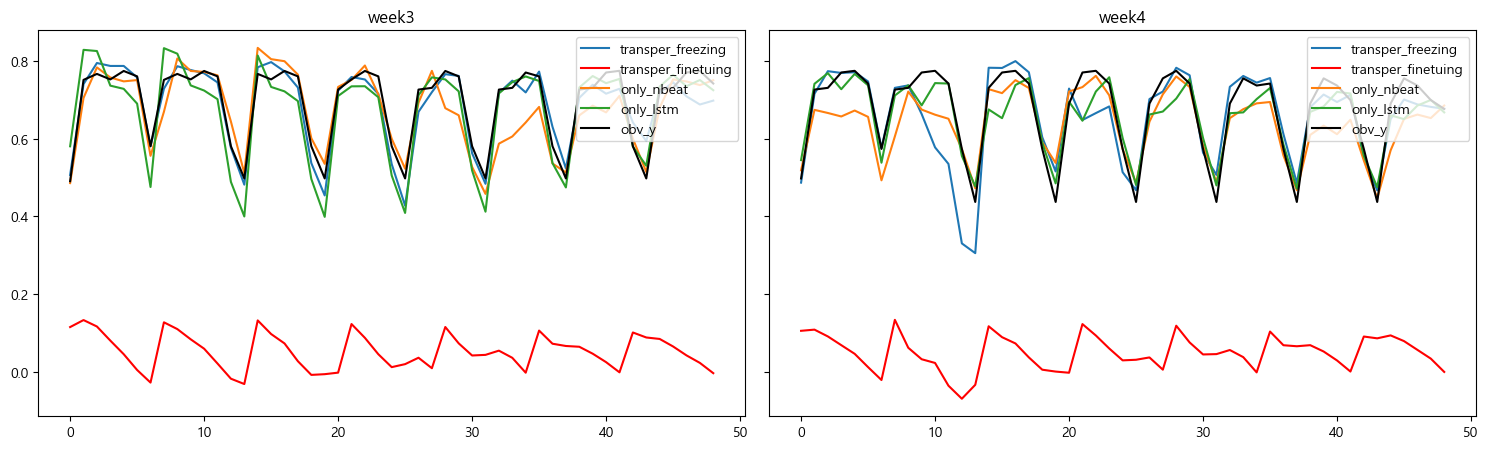

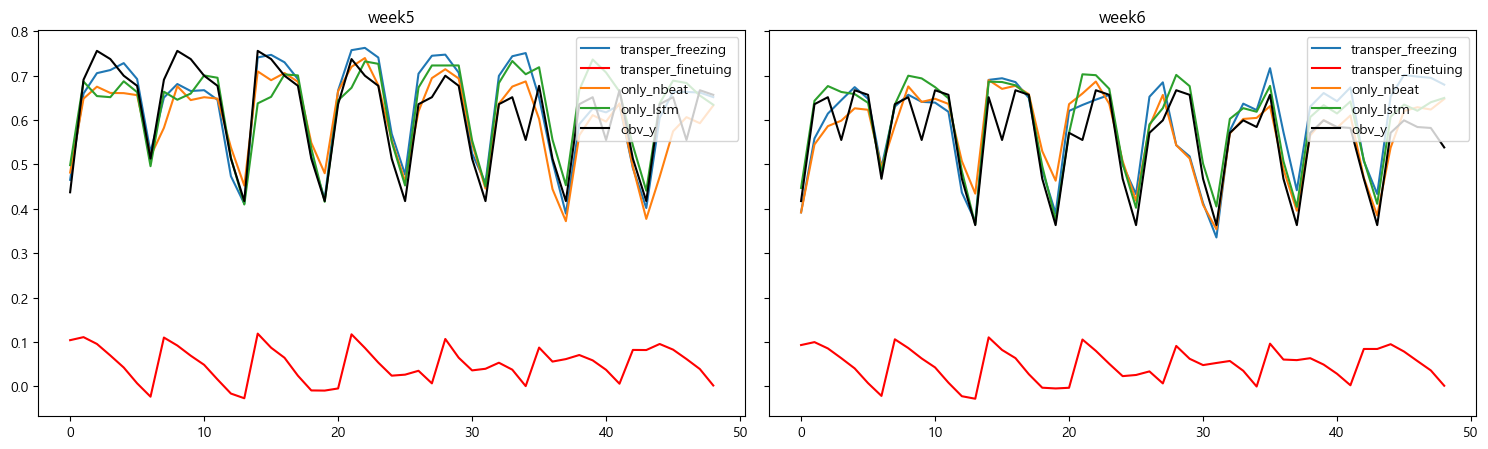

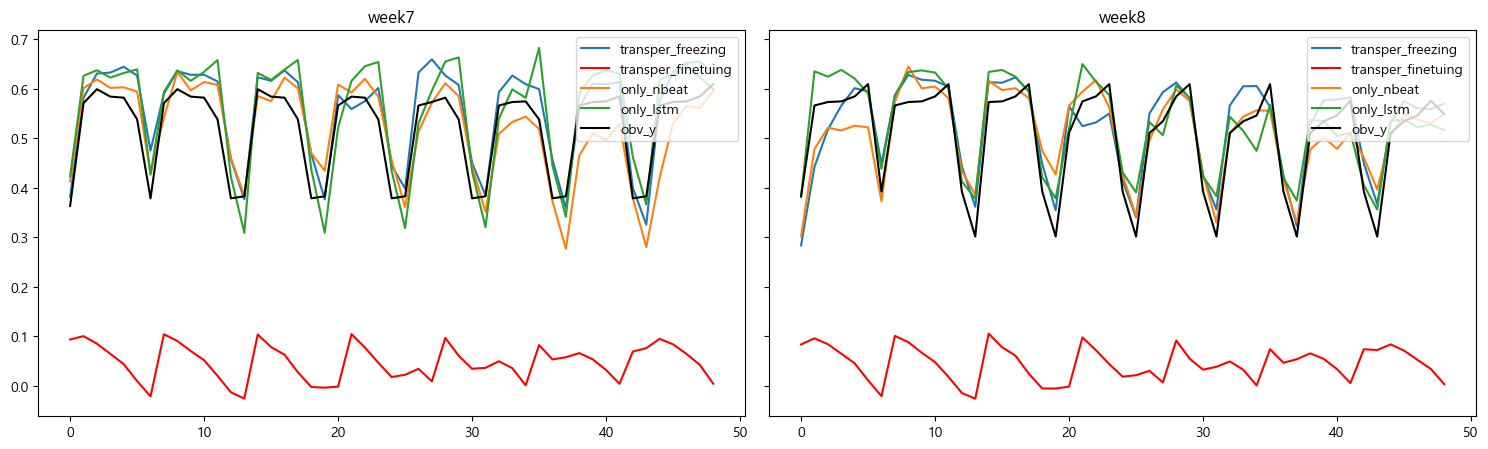

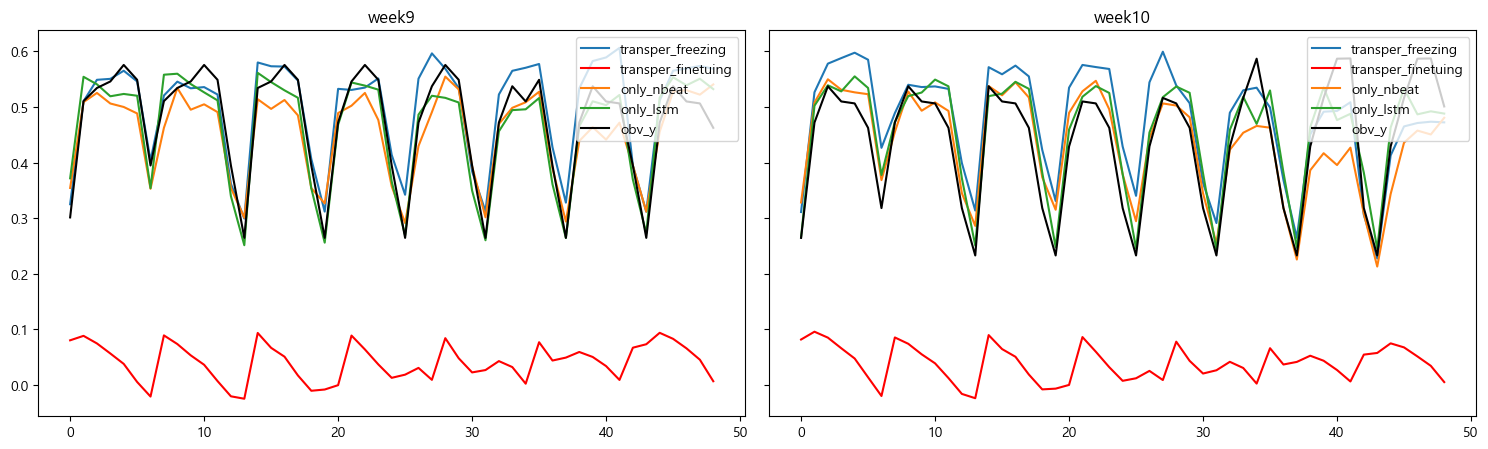

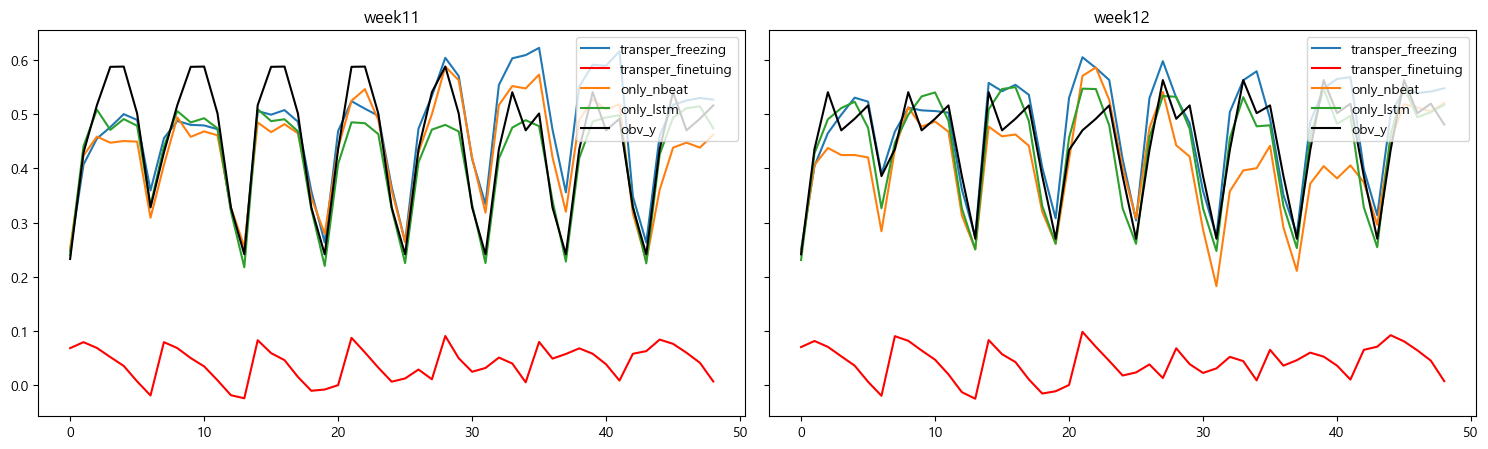

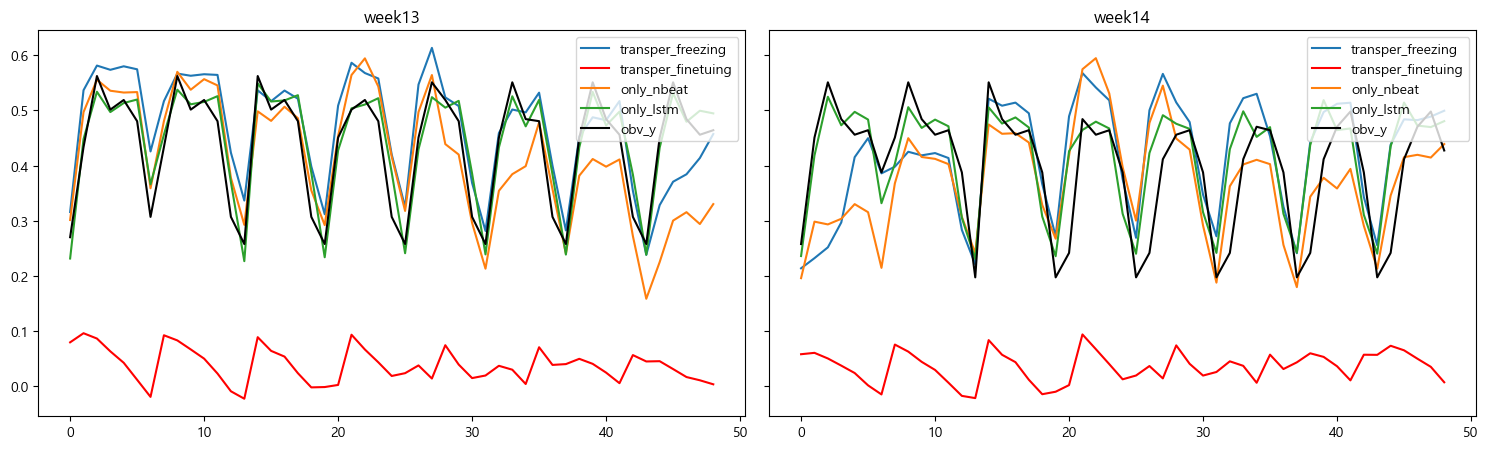

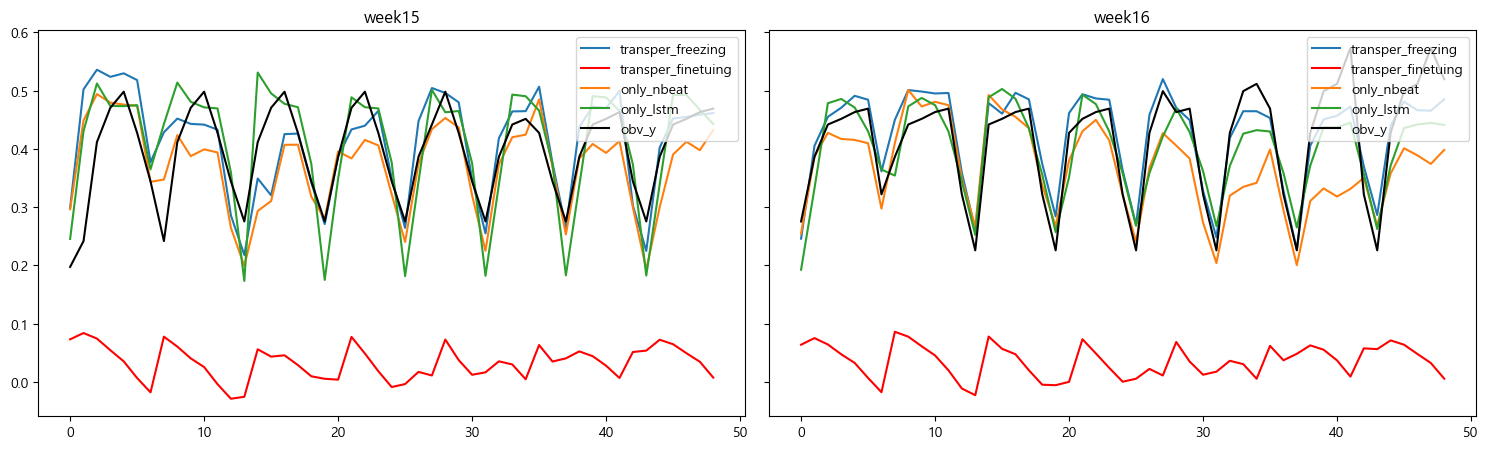

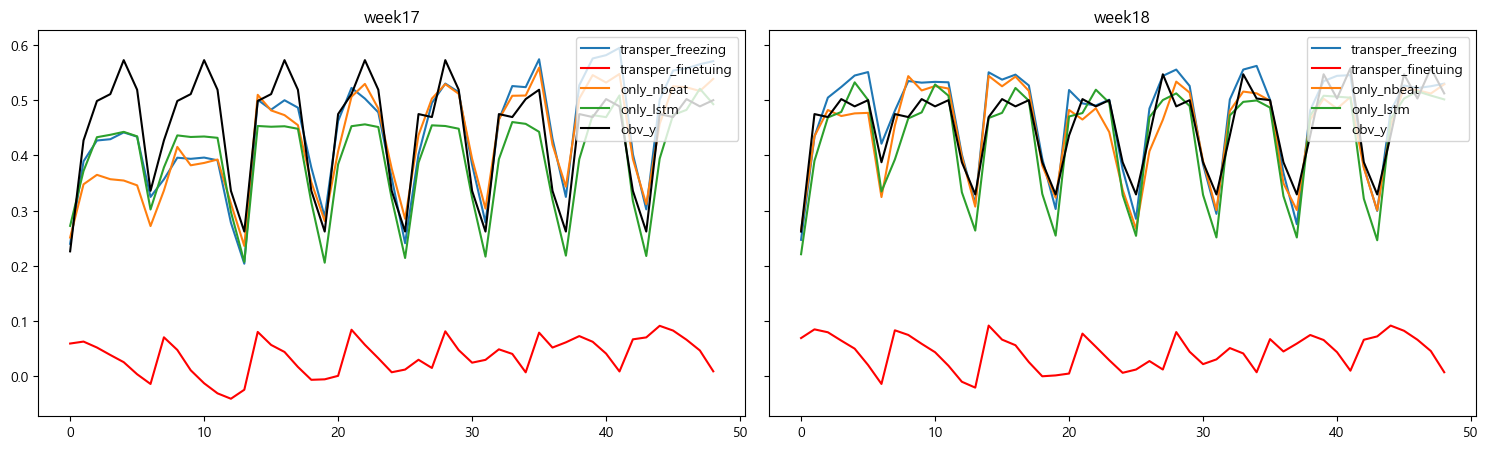

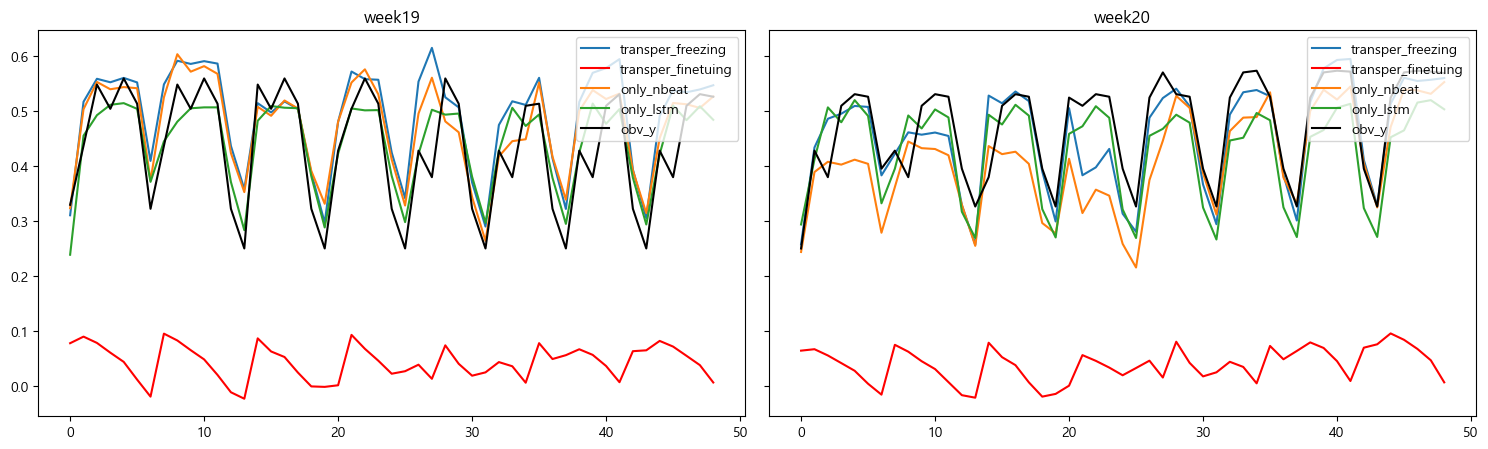

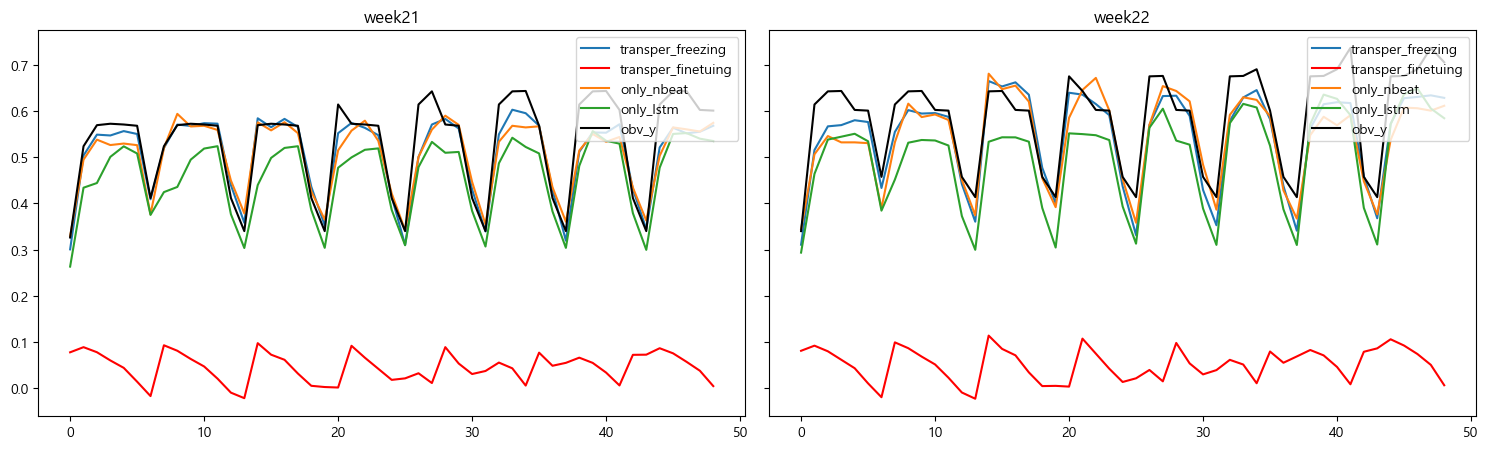

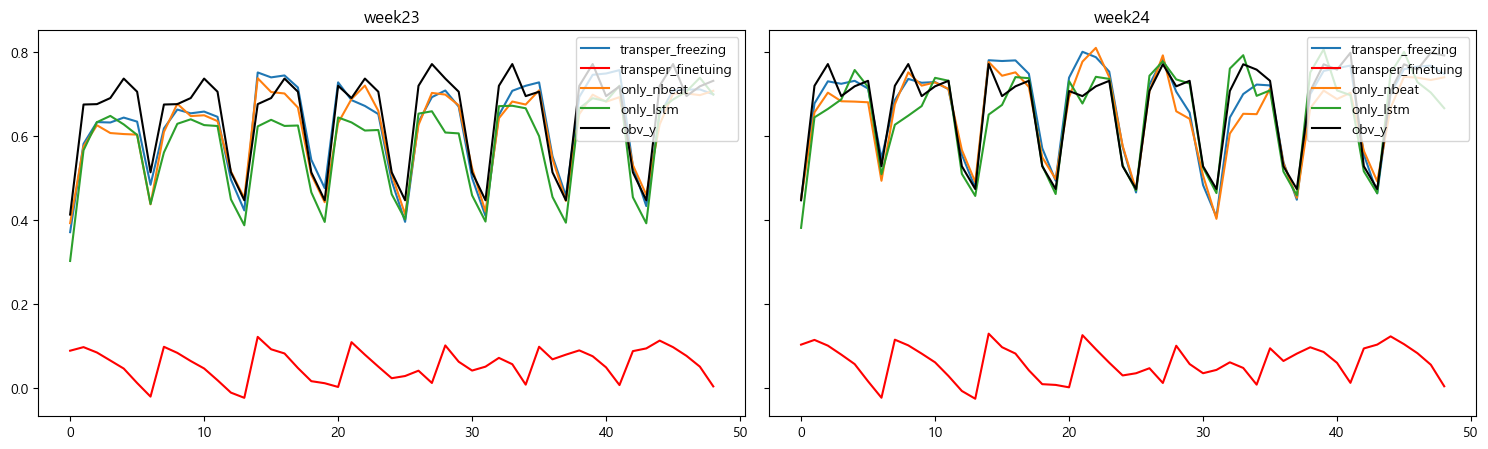

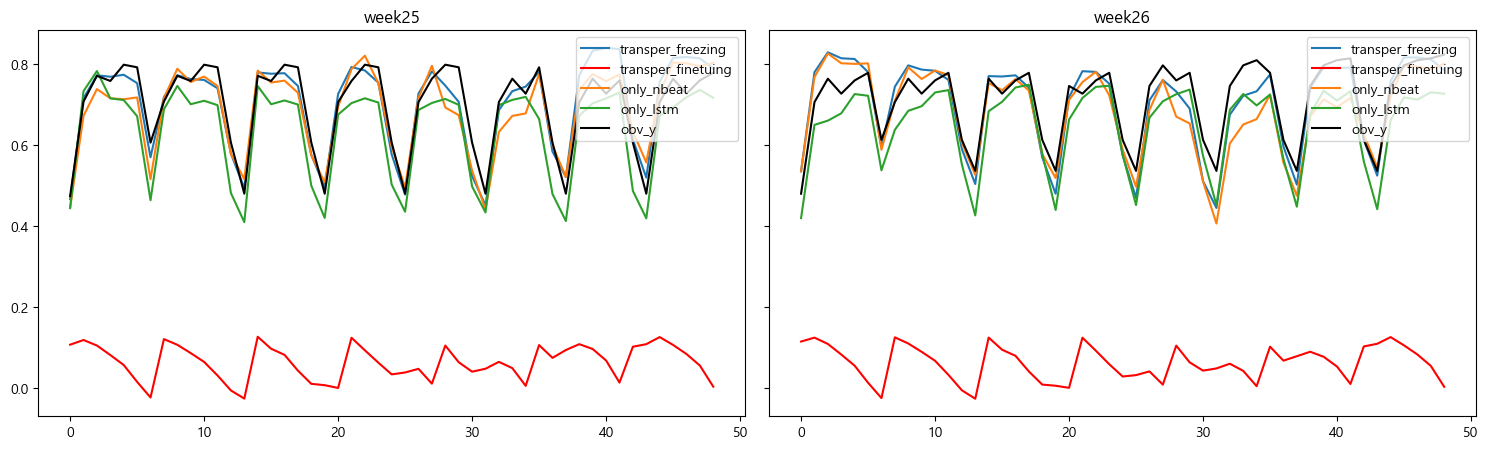

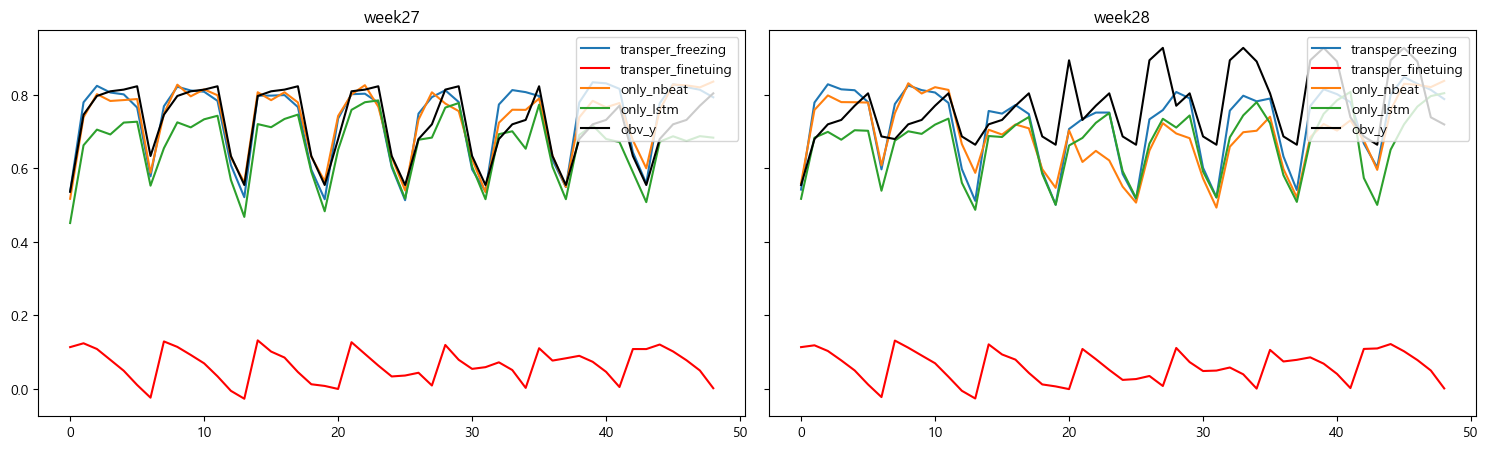

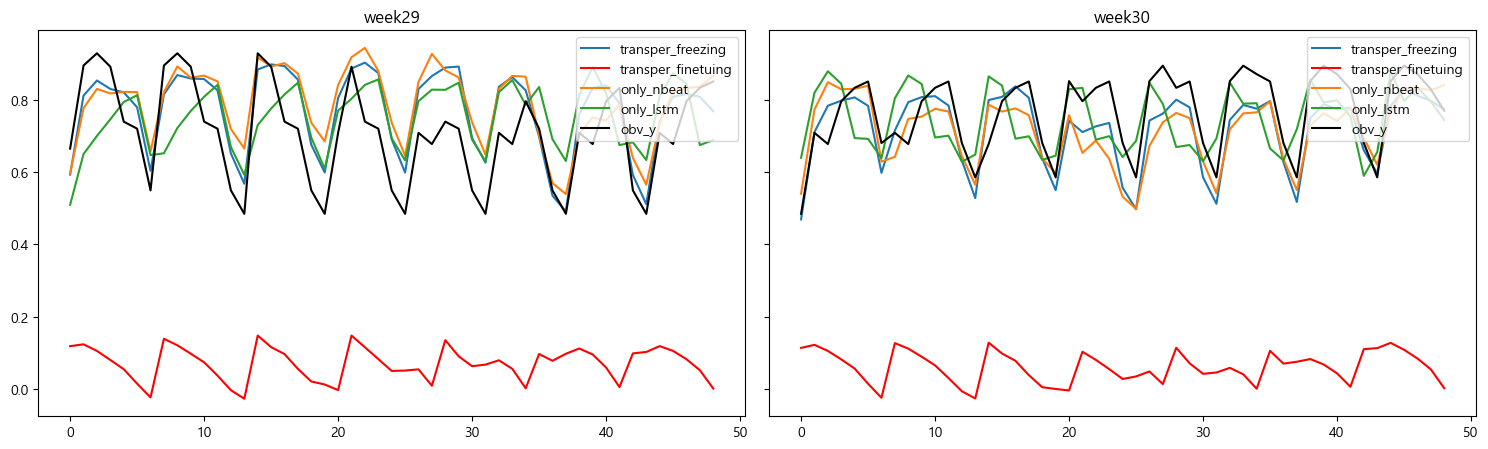

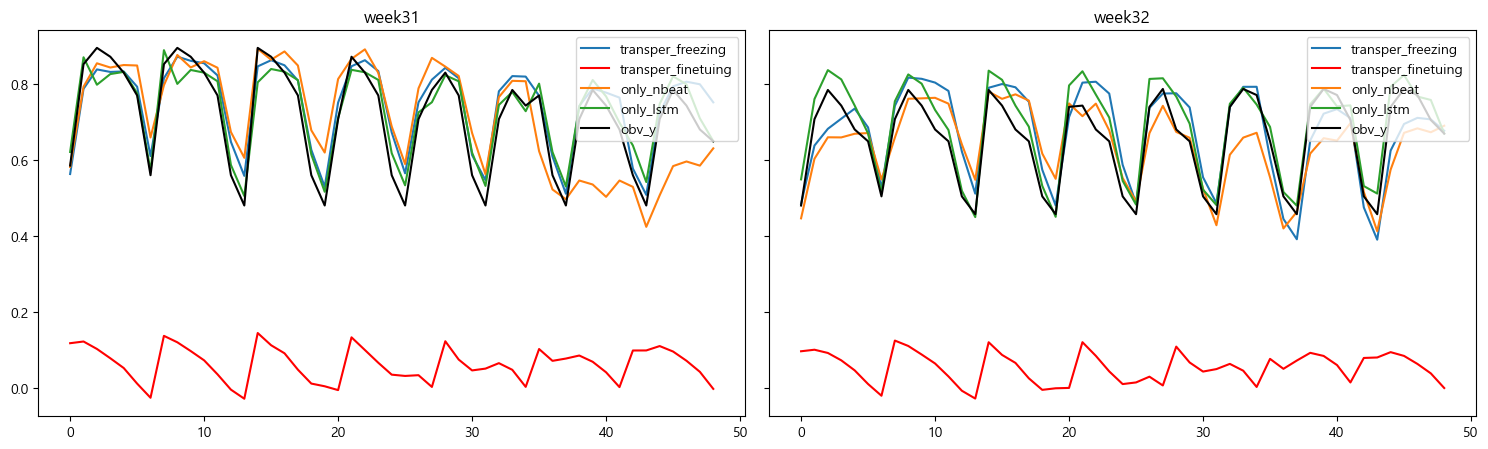

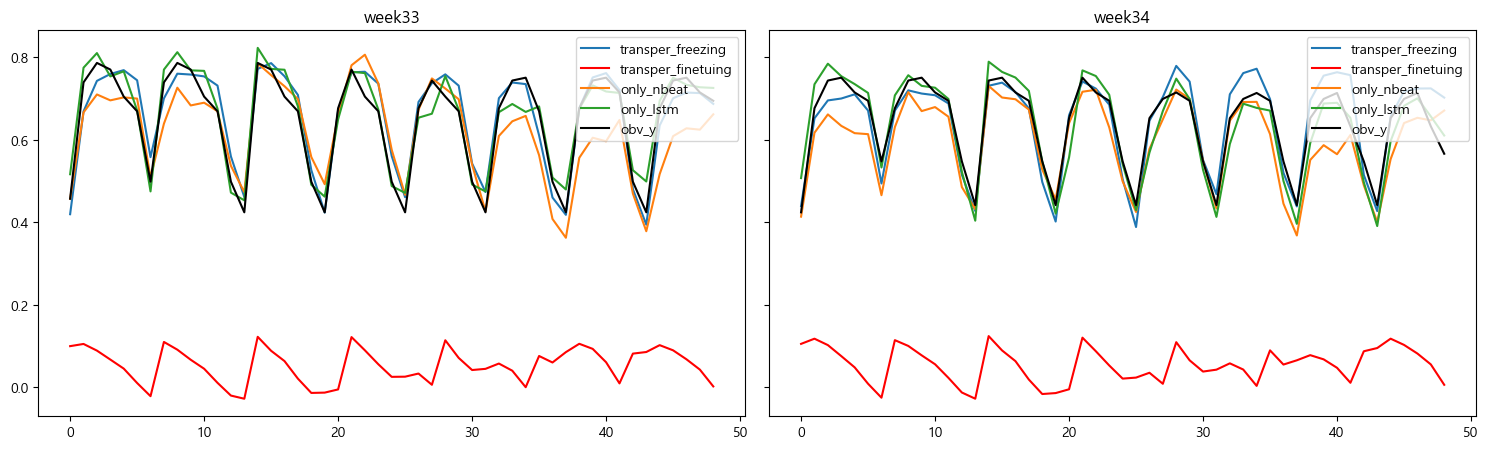

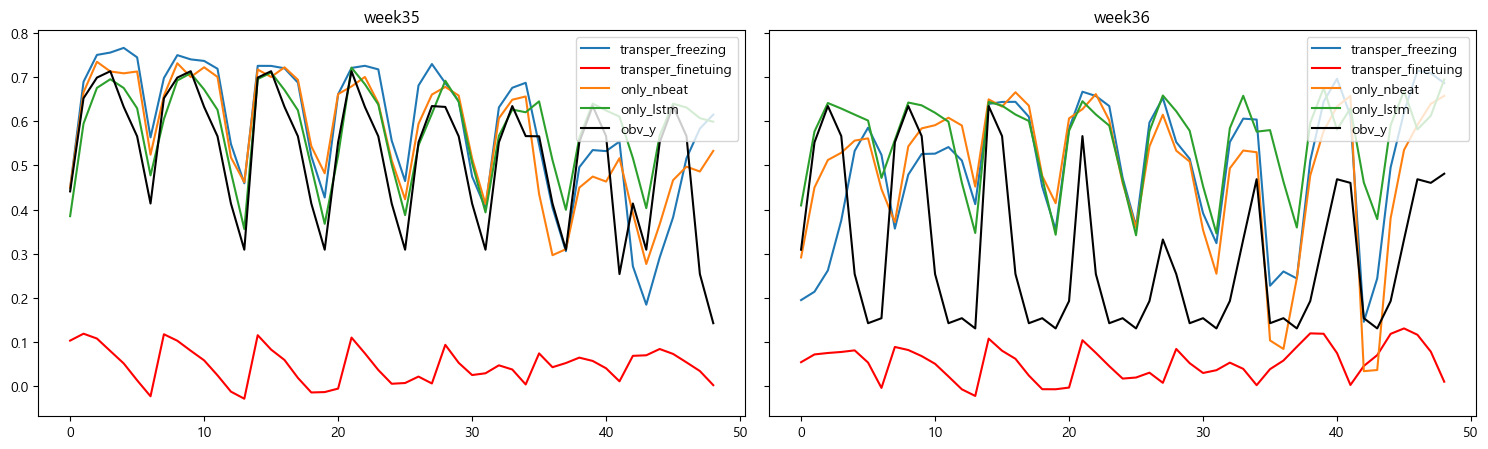

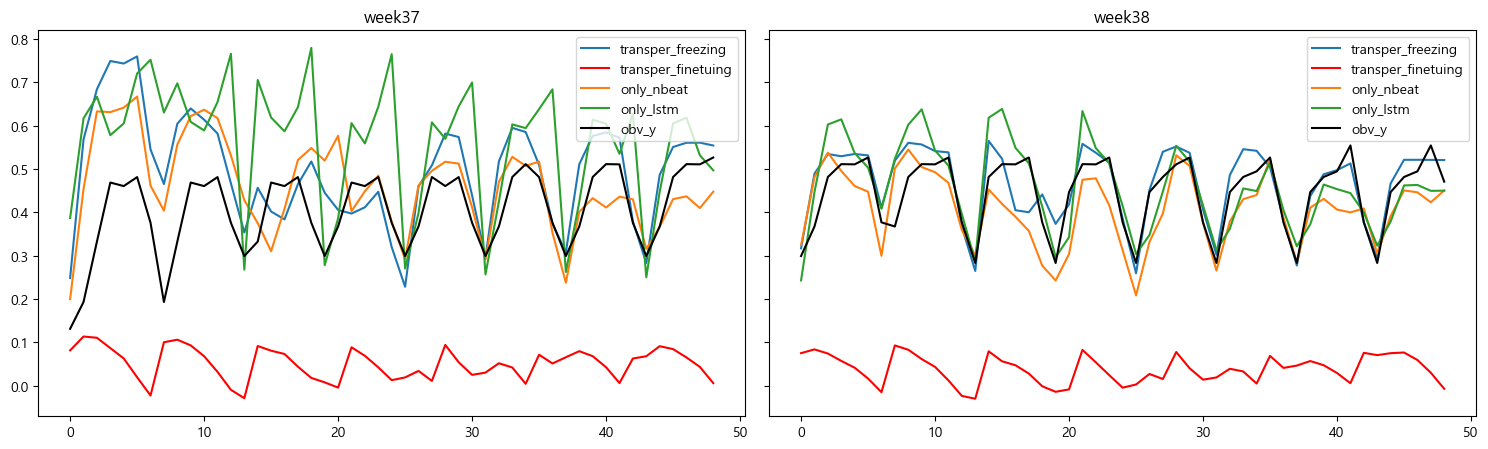

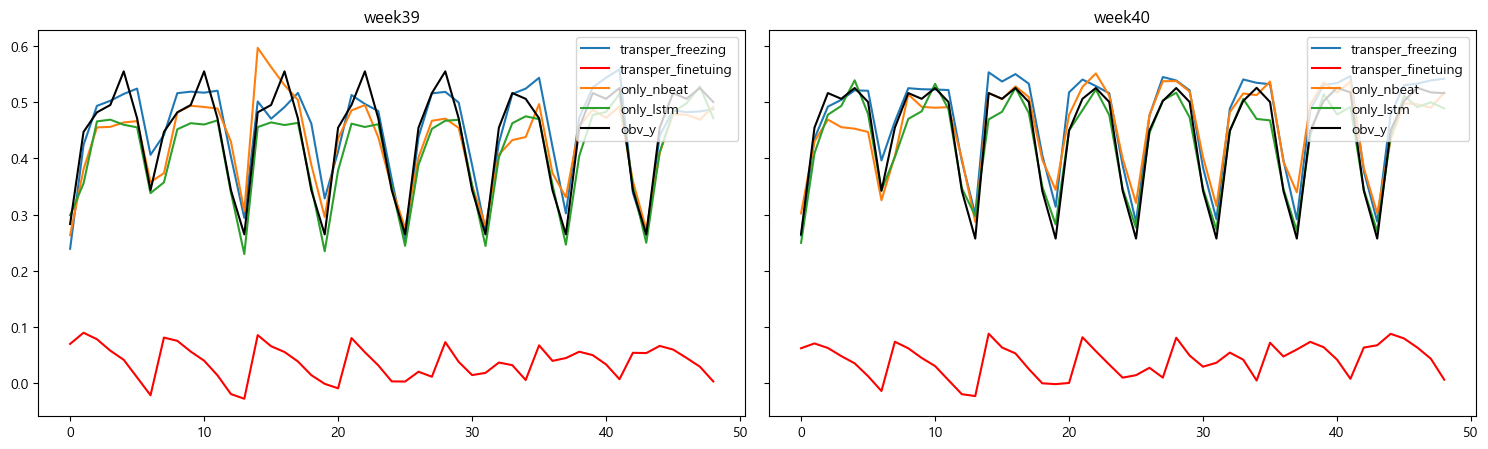

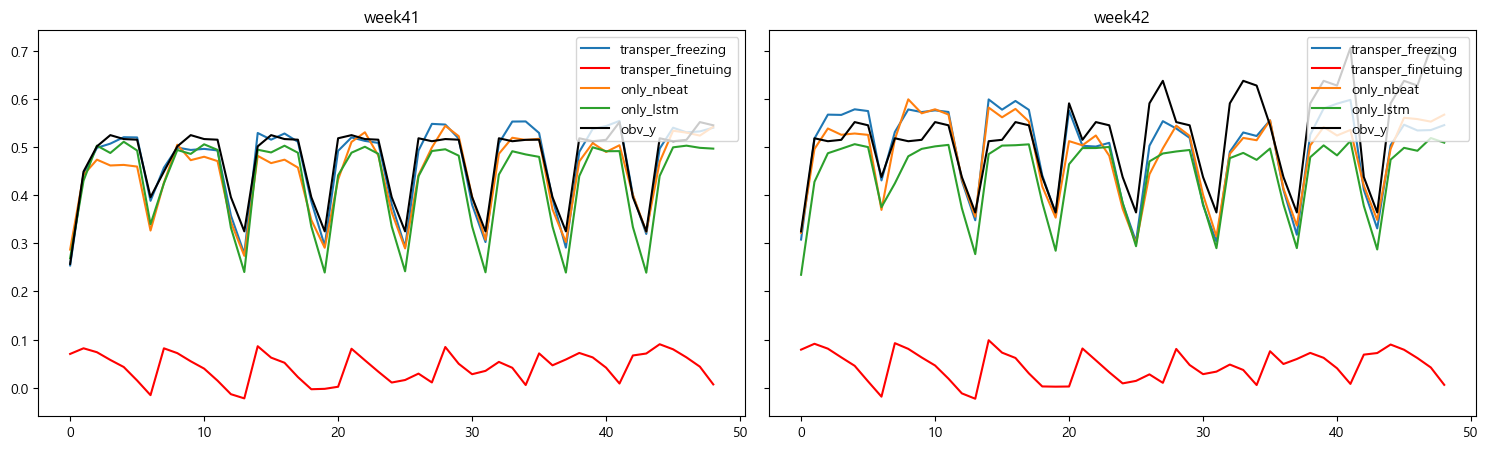

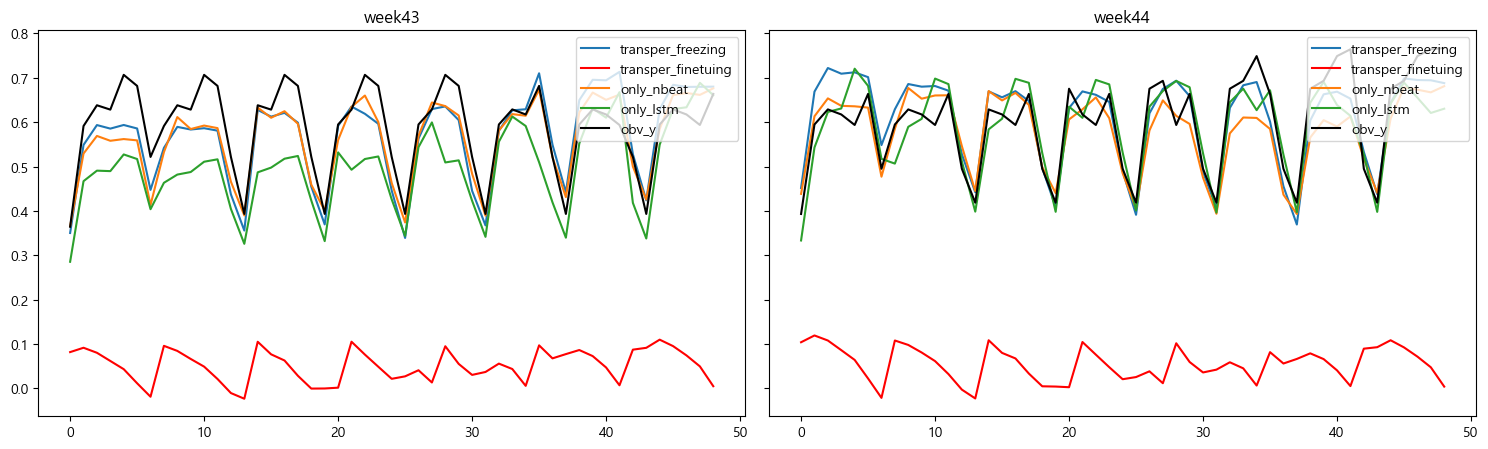

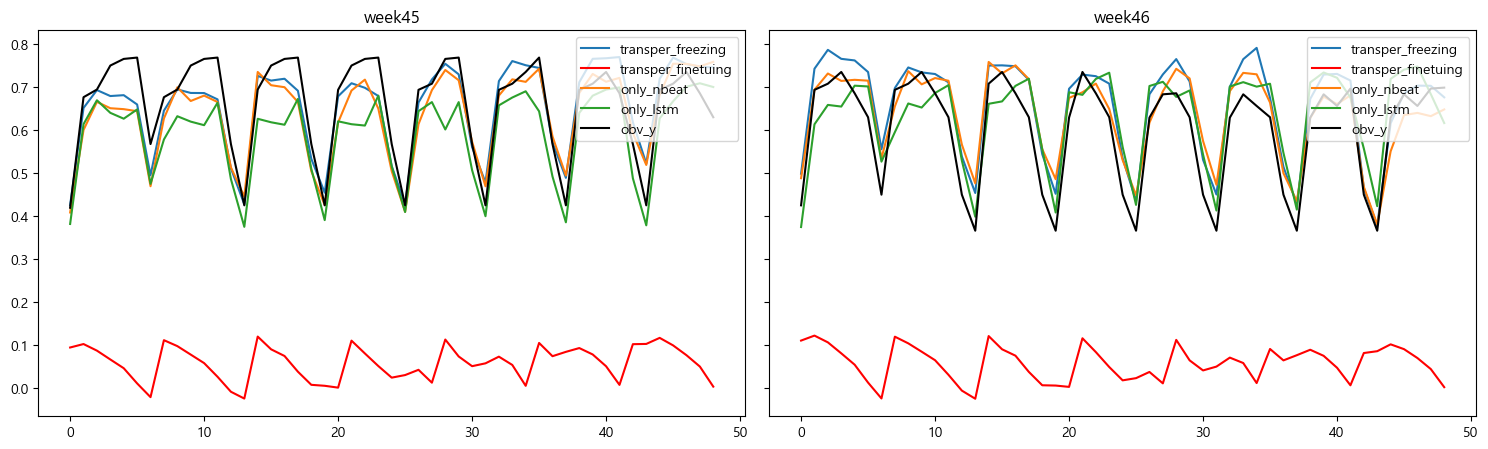

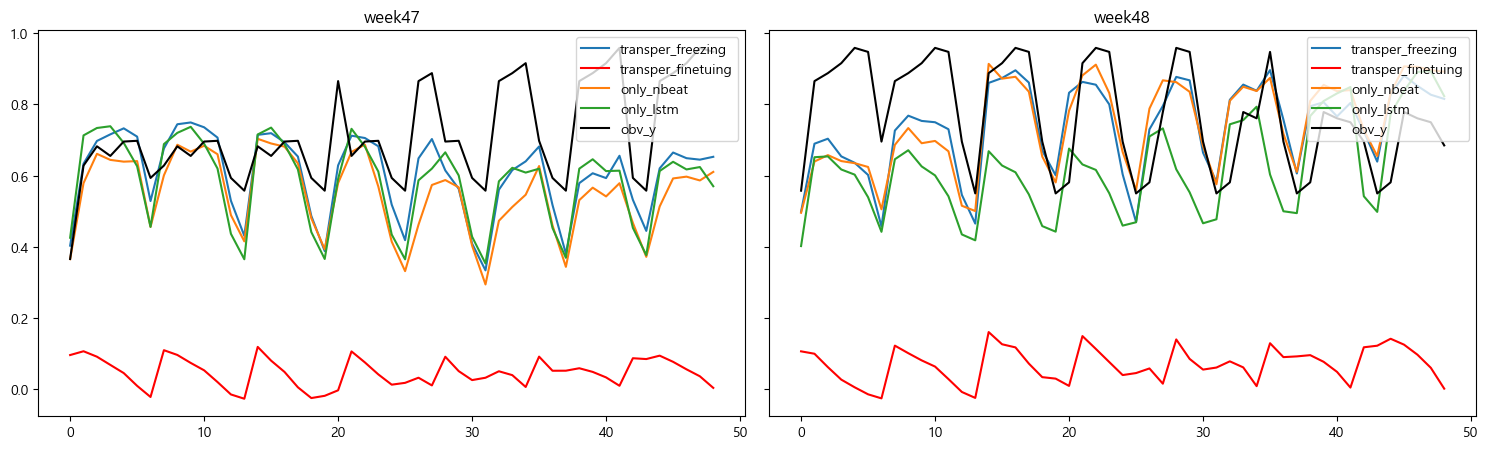

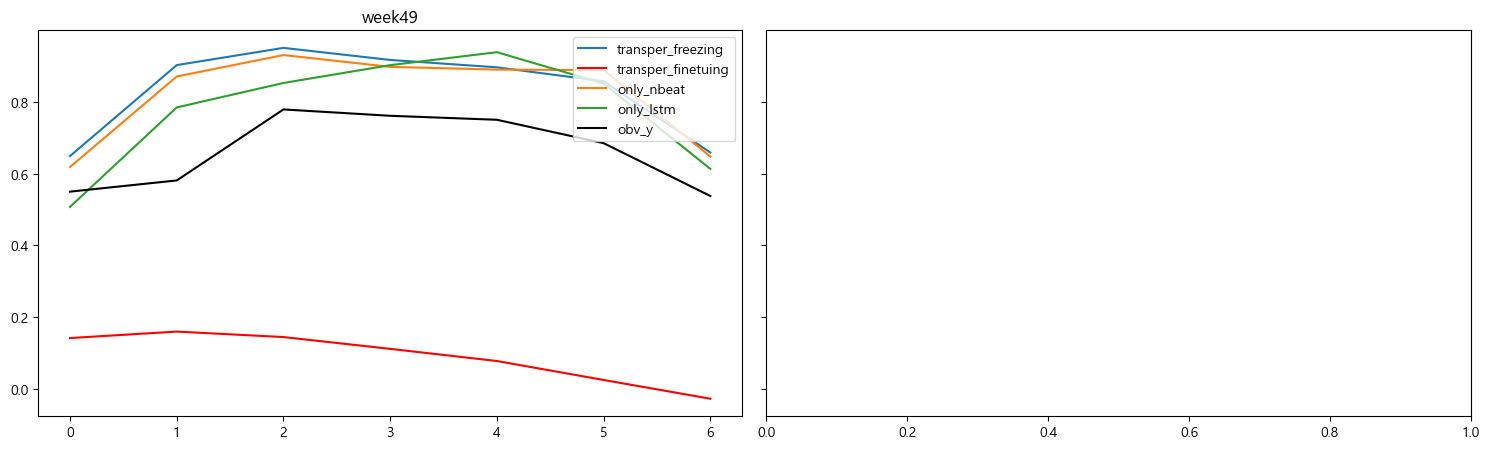

In [110]:
index_7= np.arange(0,337,7)
num = len(index_7)

def plot_group(start_index):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5),sharey=True)  # 1행 3열의 서브플롯 생성
    #fig.suptitle(f'Comparison of N-Beats, LSTM predictions, and Actual Data (Groups starting at index {start_index})')

    for i in range(2):
        index = start_index + i
        if index > num-1:
            break
        axs[i].plot([nbeats_lstm_pretrain_lst[0].reshape(-1,7)[index_7[j]:index_7[j]+7] for j in range(len(index_7))][index].flatten(), label = 'transper_freezing')
        axs[i].plot([nbeats_lstm_pretrain_lst2[0].reshape(-1,7)[index_7[j]:index_7[j]+7] for j in range(len(index_7))][index].flatten(),color = 'red', label = 'transper_finetuing')
        axs[i].plot([pred_nbeats.reshape(-1,7)[index_7[j]:index_7[j]+7] for j in range(len(index_7))][index].flatten(), label = 'only_nbeat')
        axs[i].plot([pred_lstm.reshape(-1,7)[index_7[j]:index_7[j]+7] for j in range(len(index_7))][index].flatten(), label = 'only_lstm')

        axs[i].plot([test_y[index_7[i]:index_7[i]+7] for i in range(len(index_7))][index].flatten(), label = 'obv_y',color = 'black')
#axs[i].plot([pred_lstm.reshape(-1,15)[index_7[i]:index_7[i]+7] for i in range(len(index_7))][index].flatten(), label = 'lstm')

    

        axs[i].legend(loc='upper right')
        axs[i].set_title(f'week{index+1}')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()


for start_index in range(0, num, 2):
    plot_group(start_index)